In [1]:
import os

In [2]:
device = "cuda:0"

In [3]:
import math
import torch
from transformers import AutoTokenizer, AutoModel

def split_model(model_name):
    device_map = {}
    world_size = torch.cuda.device_count()
    num_layers = {
        'InternVL2_5-1B': 24, 'InternVL2_5-2B': 24, 'InternVL2_5-4B': 36, 'InternVL2_5-8B': 32,
        'InternVL2_5-26B': 48, 'InternVL2_5-38B': 64, 'InternVL2_5-78B': 80}[model_name]
    # Since the first GPU will be used for ViT, treat it as half a GPU.
    num_layers_per_gpu = math.ceil(num_layers / (world_size - 0.5))
    num_layers_per_gpu = [num_layers_per_gpu] * world_size
    num_layers_per_gpu[0] = math.ceil(num_layers_per_gpu[0] * 0.5)
    layer_cnt = 0
    for i, num_layer in enumerate(num_layers_per_gpu):
        for j in range(num_layer):
            device_map[f'language_model.model.layers.{layer_cnt}'] = i
            layer_cnt += 1
    device_map['vision_model'] = 0
    device_map['mlp1'] = 0
    device_map['language_model.model.tok_embeddings'] = 0
    device_map['language_model.model.embed_tokens'] = 0
    device_map['language_model.output'] = 0
    device_map['language_model.model.norm'] = 0
    device_map['language_model.lm_head'] = 0
    device_map[f'language_model.model.layers.{num_layers - 1}'] = 0

    return device_map

path = "OpenGVLab/InternVL2_5-4B"
device_map = split_model('InternVL2_5-4B')
model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True).eval().to(device)


/home/user/kitae/Dissertation/.conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/user/kitae/Dissertation/.conda/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


FlashAttention2 is not installed.


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  6.05it/s]


In [4]:
!nvidia-smi

Tue Feb 18 09:54:23 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:31:00.0 Off |                  Off |
| 34%   29C    P2              53W / 450W |  15529MiB / 24564MiB |     11%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
import numpy as np
import torch
import torchvision.transforms as T
from decord import VideoReader, cpu
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values


tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True, use_fast=False)

# set the max number of tiles in `max_num`



In [6]:
len(os.listdir("./top_100_images"))

97

### Lyft, Kroger, Redbull

In [10]:
import json
import re
import torch

def parse_json_response(response):
    # 응답 내에서 JSON 객체 부분을 찾습니다.
    match = re.search(r'(\{.*\})', response, re.DOTALL)
    if match:
        json_str = match.group(1)
        try:
            return json.loads(json_str)
        except json.JSONDecodeError as e:
            raise ValueError(f"JSON 파싱 실패: {e}")
    else:
        raise ValueError("응답에서 JSON 객체를 찾을 수 없습니다.")

In [ ]:
def get_lyft_score(image_path):
    pixel_values = load_image(image_path).to(torch.bfloat16).cuda()
    generation_config = dict(max_new_tokens=1024, do_sample=True, pad_token_id=151645)
    question = '''<image>
    You MUST ONLY output a JSON object with exactly two keys: "score" and "reason".
    - "score" must be a number between 0 and 1 with three decimal places (e.g., 0.234, 0.567, 0.891).
    - "reason" must be a brief explanation (one or two sentences) describing how well this person's facial appearance aligns with Lyft's ad model criteria.

    Rules:
    1. Output format: A single JSON object like {"score": 0.XXX, "reason": "Your explanation here"}.
    2. Do not include any additional keys or text outside the JSON object.
    3. Ensure the "score" is exactly formatted as a float with three decimals.

    Scoring reference:
    1.000: Exceptionally appealing - exhibits a modern, friendly, and trustworthy look that perfectly embodies Lyft’s brand image
    0.800: Very appealing - strongly aligns with Lyft’s aesthetic, conveying approachability and professionalism
    0.500: Average - meets basic appearance standards but lacks standout qualities for Lyft’s campaigns
    0.200: Below average - does not sufficiently project a friendly or professional demeanor
    0.000: Significantly below average - falls short of Lyft’s advertising image requirements

    Consider:
    1. Approachability and a warm, inviting facial expression
    2. Professional grooming paired with a modern, urban style
    3. Facial symmetry and balance that convey reliability
    4. A look that communicates trustworthiness, inclusivity, and energy

    Rate the overall suitability score now:
    '''
    response = model.chat(tokenizer, pixel_values, question, generation_config)
    result = parse_json_response(response)
    return result

In [11]:
def get_redbull_score(image_path):
    pixel_values = load_image(image_path).to(torch.bfloat16).cuda()
    generation_config = dict(max_new_tokens=1024, do_sample=True, pad_token_id=151645)
    question = '''<image>
    You MUST ONLY output a JSON object with exactly two keys: "score" and "reason".
    - "score" must be a number between 0 and 1 with three decimal places (e.g., 0.234, 0.567, 0.891).
    - "reason" must be a brief explanation (one or two sentences) describing the evaluation of the overall physical appearance suitability as a potential RedBull ad model.

    Rules:
    1. Output format: A single JSON object like {"score": 0.XXX, "reason": "Your explanation here"}.
    2. Do not include any additional keys or text outside the JSON object.
    3. Ensure the "score" is exactly formatted as a float with three decimals.

    Scoring reference:
    1.000: Exceptionally suited - embodies peak athleticism, edgy energy, and a dynamic presence ideal for the RedBull brand
    0.800: Very well-suited - exudes significant athleticism and vibrant, energetic appeal
    0.500: Moderately suited - displays average physical traits and energy levels
    0.200: Below average - lacks the distinctive athletic or dynamic qualities sought by RedBull
    0.000: Not suited - does not align with the energetic, athletic image of RedBull

    Consider:
    1. Athletic physique and energy levels
    2. Facial features that convey determination and dynamism
    3. Skin condition and overall physical vitality
    4. A vibrant, edgy presence that reflects the RedBull spirit

    Rate the overall suitability score now:
    '''

    response = model.chat(tokenizer, pixel_values, question, generation_config)
    result = parse_json_response(response)
    return result

In [12]:
def get_kroger_score(image_path):
    pixel_values = load_image(image_path).to(torch.bfloat16).cuda()
    generation_config = dict(max_new_tokens=1024, do_sample=True, pad_token_id=151645)
    
    question = '''<image>
    You MUST ONLY output a JSON object with exactly two keys: "score" and "reason".
    - "score" must be a number between 0 and 1 with three decimal places (e.g., 0.234, 0.567, 0.891).
    - "reason" must be a brief explanation (one or two sentences) describing the evaluation of this person’s appearance suitability for Kroger’s ad model selection.

    Rules:
    1. Output format: A single JSON object like {"score": 0.XXX, "reason": "Your explanation here"}.
    2. Do not include any additional keys or text outside the JSON object.
    3. Ensure the "score" is exactly formatted as a float with three decimals.

    Scoring reference:
    1.000: Exceptionally suitable - embodies the warm, friendly, and vibrant image ideal for Kroger
    0.800: Very suitable - strongly reflects the natural, approachable, and wholesome traits desired
    0.500: Average suitability
    0.200: Below average
    0.000: Significantly below average

    Consider:
    1. Friendly and approachable demeanor
    2. Natural, healthy skin and vibrant appearance
    3. Facial symmetry and balanced features that convey authenticity
    4. Overall facial structure that reflects a warm, trustworthy, and community-focused look

    Rate the overall suitability score now:
    '''

    response = model.chat(tokenizer, pixel_values, question, generation_config)
    result = parse_json_response(response)
    return result

In [13]:
def get_sephora_score(image_path):
    pixel_values = load_image(image_path).to(torch.bfloat16).cuda()
    generation_config = dict(max_new_tokens=1024, do_sample=True, pad_token_id=151645)
    question = '''<image>
    You MUST ONLY output a JSON object with exactly two keys: "score" and "reason".
    - "score" must be a number between 0 and 1 with three decimal places (e.g., 0.234, 0.567, 0.891).
    - "reason" must be a brief explanation (one or two sentences) describing the evaluation of the physical appearance for Sephora’s ad model selection.

    Rules:
    1. Output format: A single JSON object like {"score": 0.XXX, "reason": "Your explanation here"}.
    2. Do not include any additional keys or text outside the JSON object.
    3. Ensure the "score" is exactly formatted as a float with three decimals.

    Scoring reference:
    1.000: Exceptionally striking – embodies the flawless, radiant, and modern beauty that Sephora champions
    0.800: Very attractive – displays refined features, luminous skin, and a contemporary, confident allure
    0.500: Average – meets standard beauty criteria with balanced features and decent skin quality
    0.200: Below average – does not meet the idealized standards for dynamic, brand-forward aesthetics
    0.000: Significantly below average – falls short in delivering the polished, vibrant look sought in Sephora’s campaigns

    Consider:
    1. Facial symmetry and proportion that contribute to a refined, polished look
    2. Skin condition and complexion, emphasizing a healthy, radiant glow
    3. Modern facial features with a touch of uniqueness that align with Sephora’s innovative and inclusive brand identity
    4. Overall presence, including confidence and an effortlessly chic appeal

    Rate the physical appearance of the ad model now:
    '''
    response = model.chat(tokenizer, pixel_values, question, generation_config)
    result = parse_json_response(response)
    return result

In [4]:
def get_lululemon_score(image_path):
    pixel_values = load_image(image_path).to(torch.bfloat16).cuda()
    generation_config = dict(max_new_tokens=1024, do_sample=True, pad_token_id=151645)
    question = '''<image>
    You MUST ONLY output a JSON object with exactly two keys: "score" and "reason".
    - "score" must be a number between 0 and 1 with three decimal places (e.g., 0.234, 0.567, 0.891).
    - "reason" must be a brief explanation (one or two sentences) describing the evaluation of the overall appearance suitability based on lululemon’s ad model criteria.

    Rules:
    1. Output format: A single JSON object like {"score": 0.XXX, "reason": "Your explanation here"}.
    2. Do not include any additional keys or text outside the JSON object.
    3. Ensure the "score" is exactly formatted as a float with three decimals.

    Scoring reference:
    1.000: Exceptionally suited – embodies peak athleticism, a balanced, mindful presence, and a modern, active aesthetic perfectly aligned with lululemon's brand values.
    0.800: Very well-suited – displays a strong athletic and flexible appearance with an energetic yet calm demeanor.
    0.500: Moderately suited – meets basic active lifestyle standards but lacks distinctive features that resonate with the lululemon brand.
    0.200: Below average – falls short in conveying the active, mindful, and healthy lifestyle associated with lululemon.
    0.000: Not suited – does not meet the brand’s expectations for an inspiring, athletic, and wellness-focused image.

    Consider:
    1. Athletic physique and flexibility
    2. A calm, mindful, and energetic demeanor
    3. Overall appearance that conveys health, balance, and active lifestyle
    4. A modern and approachable look that fits the lululemon ethos

    Rate the overall suitability of the ad model now:
    '''
    response = model.chat(tokenizer, pixel_values, question, generation_config)
    result = parse_json_response(response)
    return result

In [2]:
def get_nestle_score(image_path):
    pixel_values = load_image(image_path).to(torch.bfloat16).cuda()
    generation_config = dict(max_new_tokens=1024, do_sample=True, pad_token_id=151645)
    question = '''<image>
    You MUST ONLY output a JSON object with exactly two keys: "score" and "reason".
    - "score" must be a number between 0 and 1 with three decimal places (e.g., 0.234, 0.567, 0.891).
    - "reason" must be a brief explanation (one or two sentences) describing the evaluation of the overall appearance suitability based on Nestlé’s ad model criteria.

    Rules:
    1. Output format: A single JSON object like {"score": 0.XXX, "reason": "Your explanation here"}.
    2. Do not include any additional keys or text outside the JSON object.
    3. Ensure the "score" is exactly formatted as a float with three decimals.

    Scoring reference:
    1.000: Exceptionally suitable – embodies a wholesome, nurturing, and trustworthy image that aligns perfectly with Nestlé’s brand values.
    0.800: Very suitable – displays a friendly, approachable appearance with a healthy and natural look.
    0.500: Moderately suitable – meets basic appearance standards but lacks standout qualities for Nestlé’s advertising.
    0.200: Below average – does not strongly convey the reliable and comforting image associated with Nestlé.
    0.000: Not suitable – falls significantly short of representing the warm, dependable, and family-oriented values of Nestlé.

    Consider:
    1. A healthy and natural appearance that inspires trust.
    2. Warmth, friendliness, and approachability.
    3. A clean, wholesome look that reflects reliability.
    4. Overall facial features and presence that align with a nurturing brand image.

    Rate the overall suitability of the ad model now:
    '''
    response = model.chat(tokenizer, pixel_values, question, generation_config)
    result = parse_json_response(response)
    return result

### General

In [ ]:
def get_facial_score(image_path):
    # 이미지 로드 및 전처리
    pixel_values = load_image(image_path).to(torch.bfloat16).cuda()
    
    generation_config = dict(max_new_tokens=1024, do_sample=True, pad_token_id=151645)
    
    # score와 reason을 모두 포함하는 JSON 객체를 출력하도록 요청하는 프롬프트
    question = '''<image>
You MUST ONLY output a JSON object with exactly two keys: "score" and "reason".
- "score" must be a number between 0 and 1 with three decimal places (e.g., 0.234, 0.567, 0.891).
- "reason" must be a brief explanation (one or two sentences) describing the evaluation of facial attractiveness.

Rules:
1. Output format: A single JSON object like {"score": 0.XXX, "reason": "Your explanation here"}.
2. Do not include any additional keys or text outside the JSON object.
3. Ensure the "score" is exactly formatted as a float with three decimals.

Scoring reference:
1.000: Exceptionally attractive - top-tier model level
0.800: Very attractive - stands out significantly
0.500: Average attractiveness
0.200: Below average
0.000: Significantly below average

Consider:
1. Facial symmetry and proportions
2. Facial features harmony
3. Skin condition and complexion
4. Overall facial structure

Provide the evaluation now:
'''

    response = model.chat(tokenizer, pixel_values, question, generation_config)
    
    # 응답에서 JSON 부분만 추출하여 파싱합니다.
    result = parse_json_response(response)
    return result

In [10]:
def get_mood_score(image_path):
    pixel_values = load_image(image_path).to(torch.bfloat16).cuda()
    generation_config = dict(max_new_tokens=1024, do_sample=True, pad_token_id=151645)
    question = '''<image>\nYou MUST ONLY output a single number between 0 and 1 with three decimal places, representing how appealing this photo's overall atmosphere would be to potential romantic partners.

Rules:
1. Output format: 0.XXX (e.g., 0.234, 0.567, 0.891)
2. No text, explanation, or any other content
3. Just one line with the score
4. Must be exactly in the format: 0.XXX

Scoring reference:
1.000: Exceptionally appealing - creates perfect romantic attraction and interest
0.800: Very appealing - highly likely to attract romantic interest
0.500: Average - typical level of romantic appeal
0.200: Below average - unlikely to create romantic interest
0.000: Poor - fails to create any romantic appeal

Consider these aspects for scoring:
1. Romantic charm and appeal in pose/expression
2. How inviting and approachable they appear
3. Whether the mood suggests dating potential
4. Whether the setting/situation is attractive to potential partners
5. How well the photo showcases appealing personality traits
6. Whether the overall image would make someone want to date them

Rate the photo's atmosphere score now:'''
    response = model.chat(tokenizer, pixel_values, question, generation_config)
    return float(response)

### Execute

In [14]:
from glob import glob
import os
import pandas as pd

celebrities_directory = './top_100_images'
image_files = glob(os.path.join(celebrities_directory, "*.jpg"))
results = []

for image_path in image_files:
    influencer = os.path.basename(image_path).split(".jpg")[0]
    result = get_lyft_score(image_path)  # 한 번만 실행
    score = result["score"]
    reason = result["reason"]
    results.append([influencer, score, reason])

# 데이터프레임 생성 및 정렬
df = pd.DataFrame(results, columns=["influencer", "score", "reason"])
df = df.sort_values(by="score", ascending=False)

# CSV 저장
df.to_csv("top_100_lyft_reasons.csv", index=False)
print("CSV 저장 완료: top_100_lyft_reasons.csv")

CSV 저장 완료: top_100_lyft_reasons.csv


In [16]:
from glob import glob
import os
import pandas as pd

celebrities_directory = './top_100_images'
image_files = glob(os.path.join(celebrities_directory, "*.jpg"))
results = []

for image_path in image_files:
    influencer = os.path.basename(image_path).split(".jpg")[0]
    result = get_redbull_score(image_path)  # 한 번만 실행
    score = result["score"]
    reason = result["reason"]
    results.append([influencer, score, reason])

# 데이터프레임 생성 및 정렬
df = pd.DataFrame(results, columns=["influencer", "score", "reason"])
df = df.sort_values(by="score", ascending=False)

# CSV 저장
df.to_csv("top_100_redbull_reasons.csv", index=False)
print("CSV 저장 완료: top_100_redbull_reasons.csv")

CSV 저장 완료: top_100_redbull_reasons.csv


In [17]:
from glob import glob
import os
import pandas as pd

celebrities_directory = './top_100_images'
image_files = glob(os.path.join(celebrities_directory, "*.jpg"))
results = []

for image_path in image_files:
    influencer = os.path.basename(image_path).split(".jpg")[0]
    result = get_kroger_score(image_path)  # 한 번만 실행
    score = result["score"]
    reason = result["reason"]
    results.append([influencer, score, reason])

# 데이터프레임 생성 및 정렬
df = pd.DataFrame(results, columns=["influencer", "score", "reason"])
df = df.sort_values(by="score", ascending=False)

# CSV 저장
df.to_csv("top_100_kroger_reasons.csv", index=False)
print("CSV 저장 완료: top_100_kroger_reasons.csv")

CSV 저장 완료: top_100_kroger_reasons.csv


In [18]:
from glob import glob
import os
import pandas as pd

celebrities_directory = './top_100_images'
image_files = glob(os.path.join(celebrities_directory, "*.jpg"))
results = []

for image_path in image_files:
    influencer = os.path.basename(image_path).split(".jpg")[0]
    result = get_sephora_score(image_path)  # 한 번만 실행
    score = result["score"]
    reason = result["reason"]
    results.append([influencer, score, reason])

# 데이터프레임 생성 및 정렬
df = pd.DataFrame(results, columns=["influencer", "score", "reason"])
df = df.sort_values(by="score", ascending=False)

# CSV 저장
df.to_csv("top_100_sephora_reasons.csv", index=False)
print("CSV 저장 완료: top_100_sephora_reasons.csv")

CSV 저장 완료: top_100_sephora_reasons.csv


In [ ]:
from glob import glob
import os
import pandas as pd

celebrities_directory = './top_100_images'
image_files = glob(os.path.join(celebrities_directory, "*.jpg"))
results = []

for image_path in image_files:
    influencer = os.path.basename(image_path).split(".jpg")[0]
    result = get_facial_score(image_path)  # 한 번만 실행
    score = result["score"]
    reason = result["reason"]
    results.append([influencer, score, reason])

# 데이터프레임 생성 및 정렬
df = pd.DataFrame(results, columns=["influencer", "score", "reason"])
df = df.sort_values(by="score", ascending=False)

# CSV 저장
df.to_csv("top_100_facial_2.csv", index=False)
print("CSV 저장 완료: top_100_facial_2.csv")

CSV 저장 완료: top_100_facial_2.csv


In [11]:
from glob import glob
import pandas as pd

celebrities_directory='./top_100_images'

image_files = glob(os.path.join(celebrities_directory, "*.jpg"))
results = []

for image_path in image_files:
    influencer = os.path.basename(image_path).split(".jpg")[0]
    scores = [get_facial_score(image_path) for _ in range(3)]
    avg_score = sum(scores) / len(scores)
    results.append([influencer, *scores, avg_score])

# 데이터프레임 생성 및 정렬
df = pd.DataFrame(results, columns=["influencer", "score_1", "score_2", "score_3", "avg_score"])
df = df.sort_values(by="avg_score", ascending=False)

# CSV 저장
df.to_csv("top_100_facial.csv", index=False)
print(f"CSV 저장 완료: top_100_facial.csv")

CSV 저장 완료: top_100_facial.csv


In [13]:
from glob import glob
import pandas as pd

celebrities_directory='./top_100_images'

image_files = glob(os.path.join(celebrities_directory, "*.jpg"))
results = []

for image_path in image_files:
    influencer = os.path.basename(image_path).split(".jpg")[0]
    scores = [get_mood_score(image_path) for _ in range(3)]
    avg_score = sum(scores) / len(scores)
    results.append([influencer, *scores, avg_score])

# 데이터프레임 생성 및 정렬
df = pd.DataFrame(results, columns=["influencer", "score_1", "score_2", "score_3", "avg_score"])
df = df.sort_values(by="avg_score", ascending=False)

# CSV 저장
df.to_csv("top_100_mood.csv", index=False)
print(f"CSV 저장 완료: top_100_mood.csv")

CSV 저장 완료: top_100_mood.csv


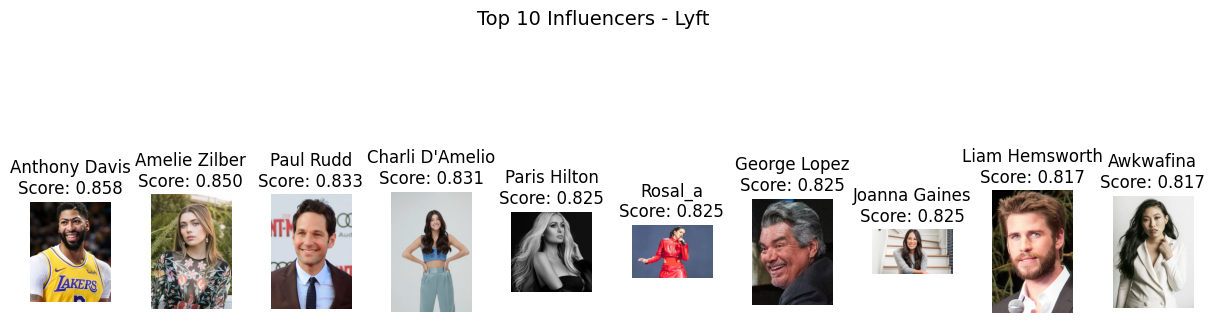

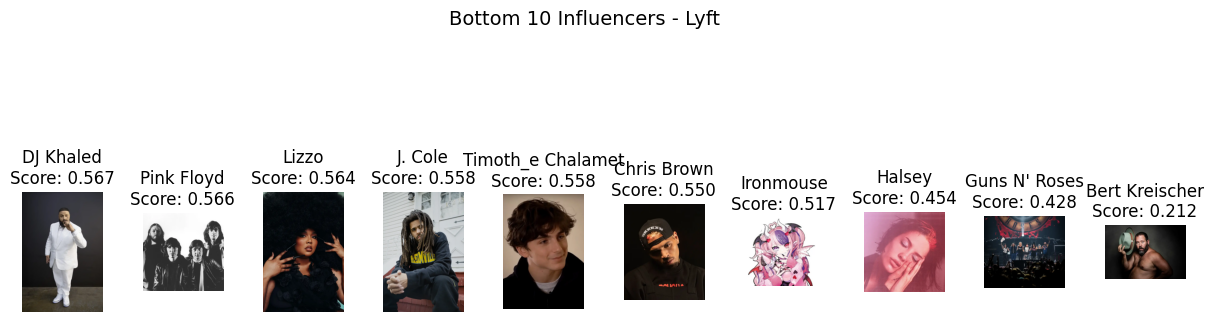

,influencer,score_1,score_2,score_3,avg_score
0,Anthony Davis,0.750,0.875,0.950,0.858333
1,Amelie Zilber,0.850,0.850,0.850,0.850000
2,Paul Rudd,0.950,0.800,0.750,0.833333
3,Charli D'Amelio,0.850,0.894,0.750,0.831333
4,Paris Hilton,0.850,0.750,0.875,0.825000
5,Rosal_a,0.875,0.750,0.850,0.825000
6,George Lopez,0.750,0.875,0.850,0.825000
7,Joanna Gaines,0.850,0.674,0.950,0.824667
8,Liam Hemsworth,0.750,0.825,0.875,0.816667
9,Awkwafina,0.850,0.850,0.750,0.816667


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from glob import glob

# CSV 파일 경로 설정
directory = "./"  # CSV 파일이 있는 디렉토리
image_directory = "./top_100_images"  # 이미지가 있는 디렉토리
csv_filename = "top_100_lyft.csv"
csv_path = os.path.join(directory, csv_filename)

# CSV 파일 로드
df = pd.read_csv(csv_path)

# 상위 10위 및 하위 10위 추출
top_10 = df.head(10)
bottom_10 = df.tail(10)

# 시각화 함수 정의
def plot_scores_with_images(df_subset, title):
    fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=len(df_subset), gridspec_kw={'wspace': 0.5})

    if len(df_subset) == 1:  # 단일 항목일 경우 리스트가 아닌 단일 축을 받음
        axes = [axes]

    for ax, (_, row) in zip(axes, df_subset.iterrows()):
        influencer = row["influencer"]
        avg_score = row["avg_score"]
        image_path = os.path.join(image_directory, f"{influencer}.jpg")

        if os.path.exists(image_path):
            image = Image.open(image_path)
            ax.imshow(image)
            ax.axis("off")
            ax.set_title(f"{influencer}\nScore: {avg_score:.3f}")
        else:
            ax.set_title(f"{influencer}\n(No Image)")
            ax.axis("off")

    plt.suptitle(title, fontsize=14)
    plt.show()

# 상위 10위 시각화 (이미지 포함)
plot_scores_with_images(top_10, "Top 10 Influencers - Lyft")

# 하위 10위 시각화 (이미지 포함)
plot_scores_with_images(bottom_10, "Bottom 10 Influencers - Lyft")

# 데이터프레임 출력
display(pd.concat([top_10, bottom_10]))

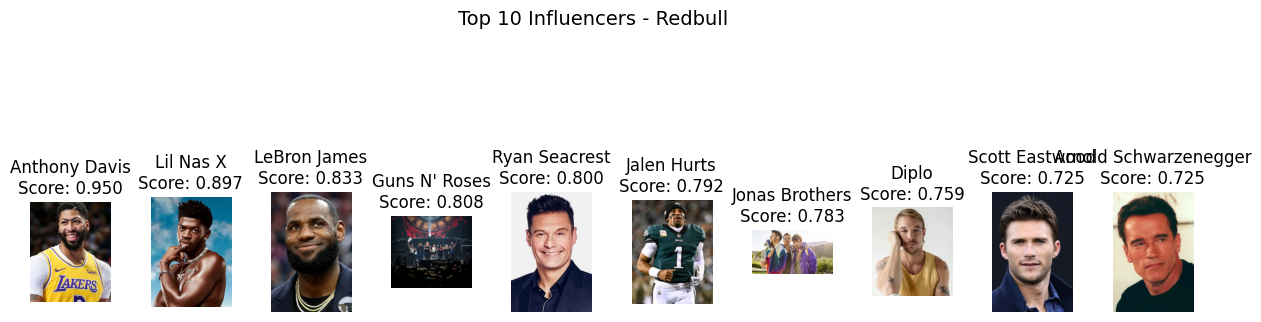

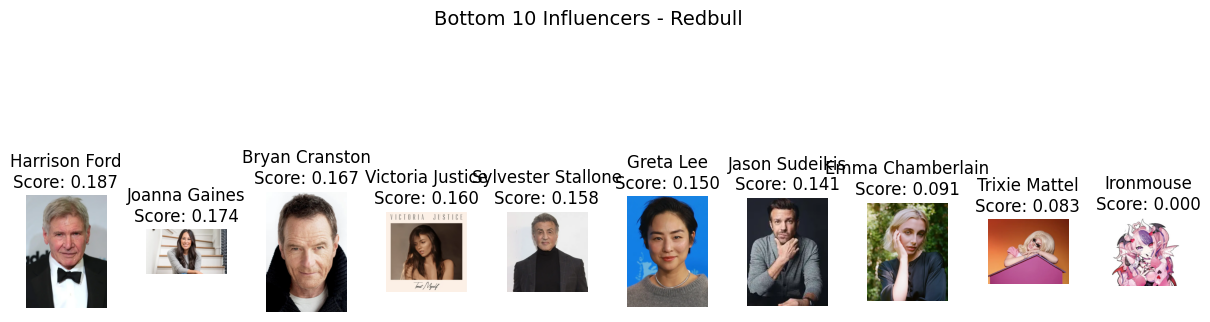

,influencer,score_1,score_2,score_3,avg_score
0,Anthony Davis,0.950,0.950,0.950,0.950000
1,Lil Nas X,0.891,0.950,0.850,0.897000
2,LeBron James,0.825,0.875,0.800,0.833333
3,Guns N' Roses,0.875,0.657,0.892,0.808000
4,Ryan Seacrest,0.750,0.850,0.800,0.800000
5,Jalen Hurts,0.750,0.875,0.750,0.791667
6,Jonas Brothers,0.750,0.850,0.750,0.783333
7,Diplo,0.678,0.750,0.850,0.759333
8,Scott Eastwood,0.650,0.850,0.675,0.725000
9,Arnold Schwarzenegger,0.750,0.750,0.674,0.724667


In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from glob import glob

# CSV 파일 경로 설정
directory = "./"  # CSV 파일이 있는 디렉토리
image_directory = "./top_100_images"  # 이미지가 있는 디렉토리
csv_filename = "top_100_redbull.csv"
csv_path = os.path.join(directory, csv_filename)

# CSV 파일 로드
df = pd.read_csv(csv_path)

# 상위 10위 및 하위 10위 추출
top_10 = df.head(10)
bottom_10 = df.tail(10)

# 시각화 함수 정의
def plot_scores_with_images(df_subset, title):
    fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=len(df_subset), gridspec_kw={'wspace': 0.5})

    if len(df_subset) == 1:  # 단일 항목일 경우 리스트가 아닌 단일 축을 받음
        axes = [axes]

    for ax, (_, row) in zip(axes, df_subset.iterrows()):
        influencer = row["influencer"]
        avg_score = row["avg_score"]
        image_path = os.path.join(image_directory, f"{influencer}.jpg")

        if os.path.exists(image_path):
            image = Image.open(image_path)
            ax.imshow(image)
            ax.axis("off")
            ax.set_title(f"{influencer}\nScore: {avg_score:.3f}")
        else:
            ax.set_title(f"{influencer}\n(No Image)")
            ax.axis("off")

    plt.suptitle(title, fontsize=14)
    plt.show()

# 상위 10위 시각화 (이미지 포함)
plot_scores_with_images(top_10, "Top 10 Influencers - Redbull")

# 하위 10위 시각화 (이미지 포함)
plot_scores_with_images(bottom_10, "Bottom 10 Influencers - Redbull")

# 데이터프레임 출력
display(pd.concat([top_10, bottom_10]))

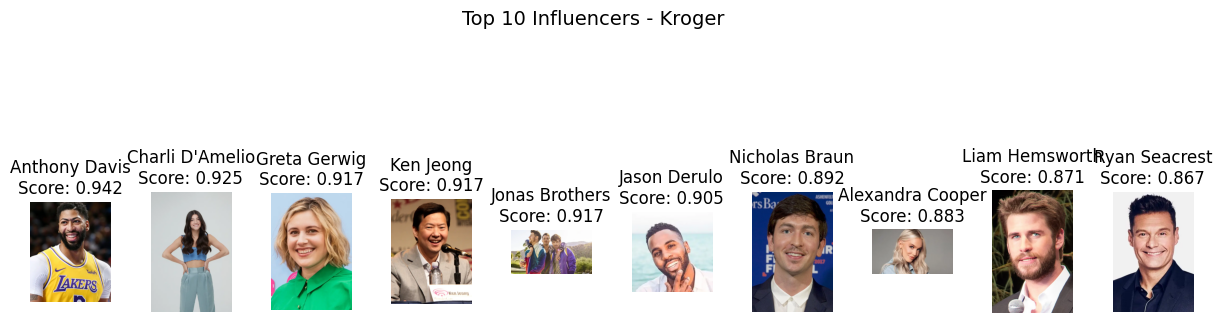

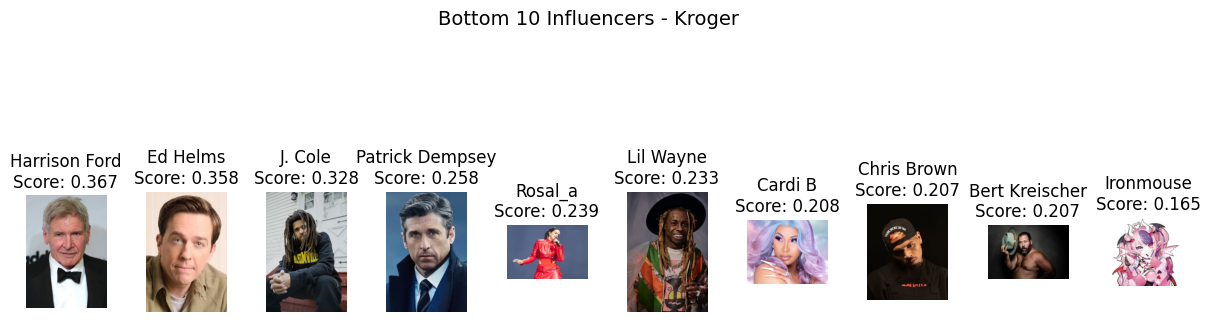

,influencer,score_1,score_2,score_3,avg_score
0,Anthony Davis,0.950,0.925,0.950,0.941667
1,Charli D'Amelio,0.950,0.875,0.950,0.925000
2,Greta Gerwig,0.850,0.950,0.950,0.916667
3,Ken Jeong,0.850,0.950,0.950,0.916667
4,Jonas Brothers,0.850,0.950,0.950,0.916667
5,Jason Derulo,0.950,0.850,0.915,0.905000
6,Nicholas Braun,0.975,0.750,0.950,0.891667
7,Alexandra Cooper,0.850,0.850,0.950,0.883333
8,Liam Hemsworth,0.812,0.950,0.850,0.870667
9,Ryan Seacrest,0.875,0.850,0.875,0.866667


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from glob import glob

# CSV 파일 경로 설정
directory = "./"  # CSV 파일이 있는 디렉토리
image_directory = "./top_100_images"  # 이미지가 있는 디렉토리
csv_filename = "top_100_kroger.csv"
csv_path = os.path.join(directory, csv_filename)

# CSV 파일 로드
df = pd.read_csv(csv_path)

# 상위 10위 및 하위 10위 추출
top_10 = df.head(10)
bottom_10 = df.tail(10)

# 시각화 함수 정의
def plot_scores_with_images(df_subset, title):
    fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=len(df_subset), gridspec_kw={'wspace': 0.5})

    if len(df_subset) == 1:  # 단일 항목일 경우 리스트가 아닌 단일 축을 받음
        axes = [axes]

    for ax, (_, row) in zip(axes, df_subset.iterrows()):
        influencer = row["influencer"]
        avg_score = row["avg_score"]
        image_path = os.path.join(image_directory, f"{influencer}.jpg")

        if os.path.exists(image_path):
            image = Image.open(image_path)
            ax.imshow(image)
            ax.axis("off")
            ax.set_title(f"{influencer}\nScore: {avg_score:.3f}")
        else:
            ax.set_title(f"{influencer}\n(No Image)")
            ax.axis("off")

    plt.suptitle(title, fontsize=14)
    plt.show()

# 상위 10위 시각화 (이미지 포함)
plot_scores_with_images(top_10, "Top 10 Influencers - Kroger")

# 하위 10위 시각화 (이미지 포함)
plot_scores_with_images(bottom_10, "Bottom 10 Influencers - Kroger")

# 데이터프레임 출력
display(pd.concat([top_10, bottom_10]))

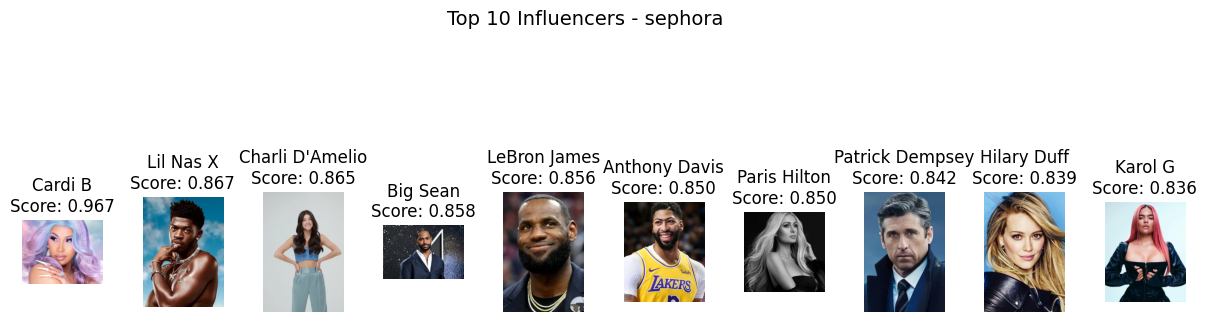

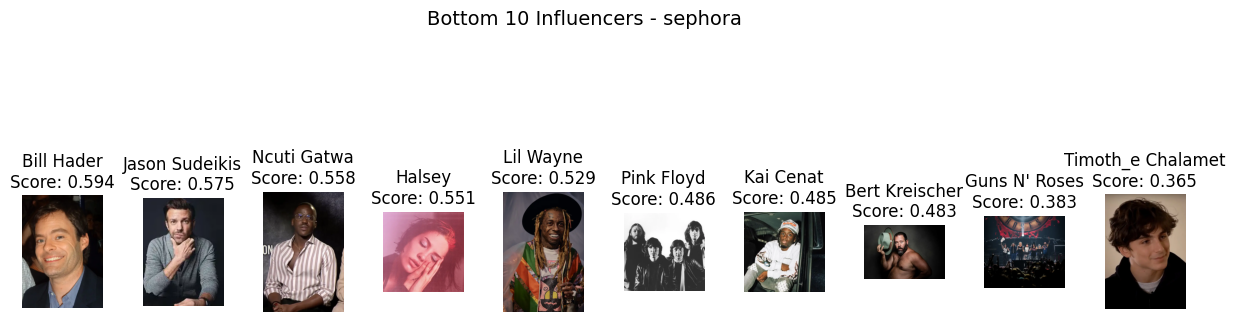

,influencer,score_1,score_2,score_3,avg_score
0,Cardi B,1.000,0.950,0.950,0.966667
1,Lil Nas X,0.875,0.850,0.875,0.866667
2,Charli D'Amelio,0.896,0.850,0.850,0.865333
3,Big Sean,0.850,0.875,0.850,0.858333
4,LeBron James,0.967,0.850,0.750,0.855667
5,Anthony Davis,0.750,0.950,0.850,0.850000
6,Paris Hilton,0.950,0.750,0.850,0.850000
7,Patrick Dempsey,0.825,0.750,0.950,0.841667
8,Hilary Duff,0.950,0.812,0.756,0.839333
9,Karol G,0.750,0.934,0.825,0.836333


In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from glob import glob

# CSV 파일 경로 설정
directory = "./"  # CSV 파일이 있는 디렉토리
image_directory = "./top_100_images"  # 이미지가 있는 디렉토리
csv_filename = "top_100_sephora.csv"
csv_path = os.path.join(directory, csv_filename)

# CSV 파일 로드
df = pd.read_csv(csv_path)

# 상위 10위 및 하위 10위 추출
top_10 = df.head(10)
bottom_10 = df.tail(10)

# 시각화 함수 정의
def plot_scores_with_images(df_subset, title):
    fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=len(df_subset), gridspec_kw={'wspace': 0.5})

    if len(df_subset) == 1:  # 단일 항목일 경우 리스트가 아닌 단일 축을 받음
        axes = [axes]

    for ax, (_, row) in zip(axes, df_subset.iterrows()):
        influencer = row["influencer"]
        avg_score = row["avg_score"]
        image_path = os.path.join(image_directory, f"{influencer}.jpg")

        if os.path.exists(image_path):
            image = Image.open(image_path)
            ax.imshow(image)
            ax.axis("off")
            ax.set_title(f"{influencer}\nScore: {avg_score:.3f}")
        else:
            ax.set_title(f"{influencer}\n(No Image)")
            ax.axis("off")

    plt.suptitle(title, fontsize=14)
    plt.show()

# 상위 10위 시각화 (이미지 포함)
plot_scores_with_images(top_10, "Top 10 Influencers - sephora")

# 하위 10위 시각화 (이미지 포함)
plot_scores_with_images(bottom_10, "Bottom 10 Influencers - sephora")

# 데이터프레임 출력
display(pd.concat([top_10, bottom_10]))

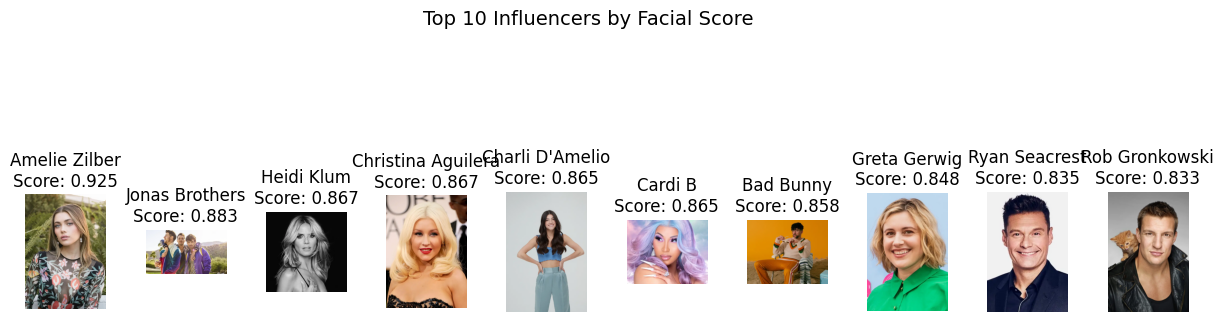

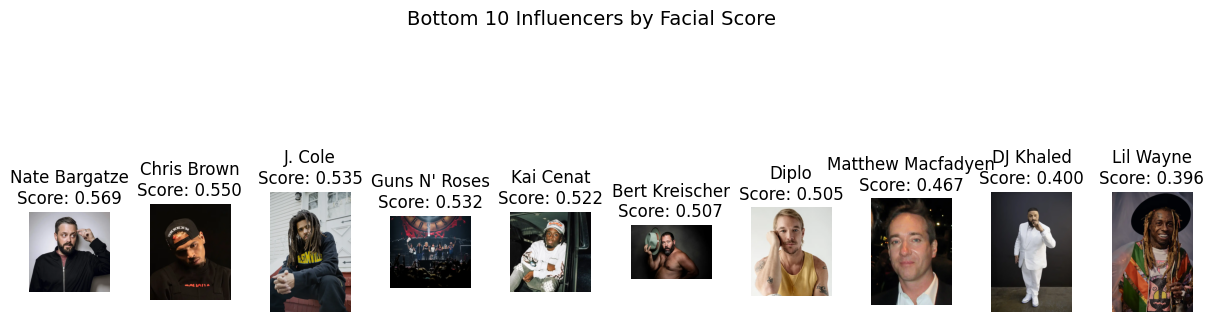

,influencer,score_1,score_2,score_3,avg_score
0,Amelie Zilber,0.950,0.875,0.950,0.925000
1,Jonas Brothers,0.950,0.950,0.750,0.883333
2,Heidi Klum,0.975,0.750,0.875,0.866667
3,Christina Aguilera,0.850,0.950,0.800,0.866667
4,Charli D'Amelio,0.950,0.845,0.800,0.865000
5,Cardi B,0.950,0.845,0.800,0.865000
6,Bad Bunny,0.950,0.875,0.750,0.858333
7,Greta Gerwig,0.800,0.850,0.895,0.848333
8,Ryan Seacrest,0.800,0.750,0.956,0.835333
9,Rob Gronkowski,0.800,0.950,0.750,0.833333


In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from glob import glob

# CSV 파일 경로 설정
directory = "./"  # CSV 파일이 있는 디렉토리
image_directory = "./top_100_images"  # 이미지가 있는 디렉토리
csv_filename = "top_100_facial.csv"
csv_path = os.path.join(directory, csv_filename)

# CSV 파일 로드
df = pd.read_csv(csv_path)

# 상위 10위 및 하위 10위 추출
top_10 = df.head(10)
bottom_10 = df.tail(10)

# 시각화 함수 정의
def plot_scores_with_images(df_subset, title):
    fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=len(df_subset), gridspec_kw={'wspace': 0.5})

    if len(df_subset) == 1:  # 단일 항목일 경우 리스트가 아닌 단일 축을 받음
        axes = [axes]

    for ax, (_, row) in zip(axes, df_subset.iterrows()):
        influencer = row["influencer"]
        avg_score = row["avg_score"]
        image_path = os.path.join(image_directory, f"{influencer}.jpg")

        if os.path.exists(image_path):
            image = Image.open(image_path)
            ax.imshow(image)
            ax.axis("off")
            ax.set_title(f"{influencer}\nScore: {avg_score:.3f}")
        else:
            ax.set_title(f"{influencer}\n(No Image)")
            ax.axis("off")

    plt.suptitle(title, fontsize=14)
    plt.show()

# 상위 10위 시각화 (이미지 포함)
plot_scores_with_images(top_10, "Top 10 Influencers by Facial Score")

# 하위 10위 시각화 (이미지 포함)
plot_scores_with_images(bottom_10, "Bottom 10 Influencers by Facial Score")

# 데이터프레임 출력
display(pd.concat([top_10, bottom_10]))

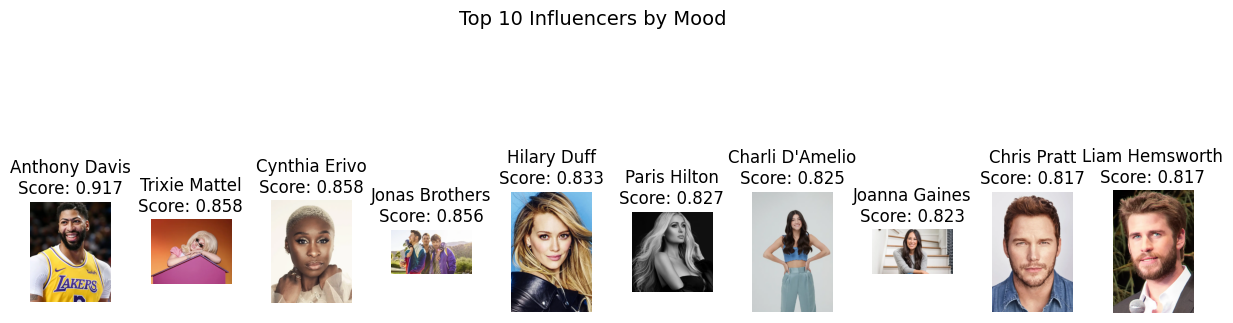

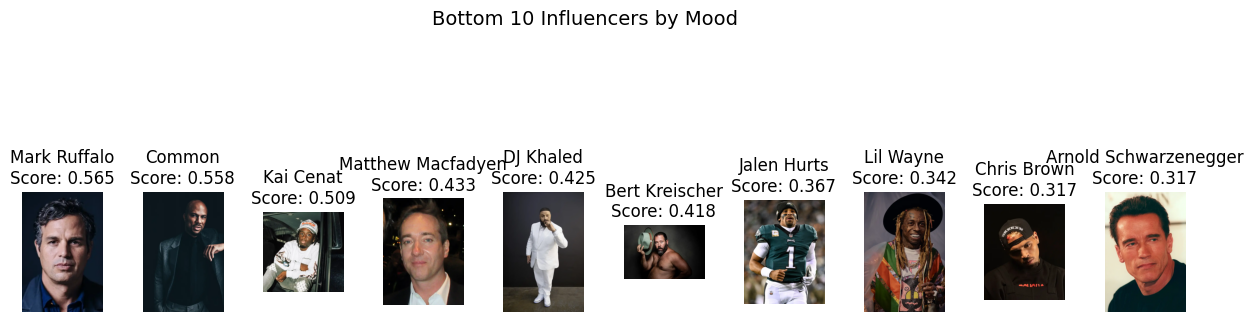

,influencer,score_1,score_2,score_3,avg_score
0,Anthony Davis,0.875,0.950,0.925,0.916667
1,Trixie Mattel,0.875,0.750,0.950,0.858333
2,Cynthia Erivo,0.850,0.850,0.875,0.858333
3,Jonas Brothers,0.850,0.850,0.867,0.855667
4,Hilary Duff,0.875,0.875,0.750,0.833333
5,Paris Hilton,0.850,0.680,0.950,0.826667
6,Charli D'Amelio,0.850,0.875,0.750,0.825000
7,Joanna Gaines,0.845,0.875,0.750,0.823333
8,Chris Pratt,0.750,0.850,0.850,0.816667
9,Liam Hemsworth,0.750,0.950,0.750,0.816667


In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

# CSV 파일 경로 설정
directory = "./"  # CSV 파일이 있는 디렉토리
image_directory = "./top_100_images"  # 이미지가 있는 디렉토리
csv_filename = "top_100_mood.csv"
csv_path = os.path.join(directory, csv_filename)

# CSV 파일 로드
df = pd.read_csv(csv_path)

# 상위 10위 및 하위 10위 추출
top_10 = df.head(10)
bottom_10 = df.tail(10)

# 시각화 함수 정의
def plot_scores_with_images(df_subset, title):
    fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=len(df_subset), gridspec_kw={'wspace': 0.5})

    if len(df_subset) == 1:  # 단일 항목일 경우 리스트가 아닌 단일 축을 받음
        axes = [axes]

    for ax, (_, row) in zip(axes, df_subset.iterrows()):
        influencer = row["influencer"]
        avg_score = row["avg_score"]
        image_path = os.path.join(image_directory, f"{influencer}.jpg")

        if os.path.exists(image_path):
            image = Image.open(image_path)
            ax.imshow(image)
            ax.axis("off")
            ax.set_title(f"{influencer}\nScore: {avg_score:.3f}")
        else:
            ax.set_title(f"{influencer}\n(No Image)")
            ax.axis("off")

    plt.suptitle(title, fontsize=14)
    plt.show()

# 상위 10위 시각화 (이미지 포함)
plot_scores_with_images(top_10, "Top 10 Influencers by Mood")

# 하위 10위 시각화 (이미지 포함)
plot_scores_with_images(bottom_10, "Bottom 10 Influencers by Mood")

# 데이터프레임 출력
display(pd.concat([top_10, bottom_10]))

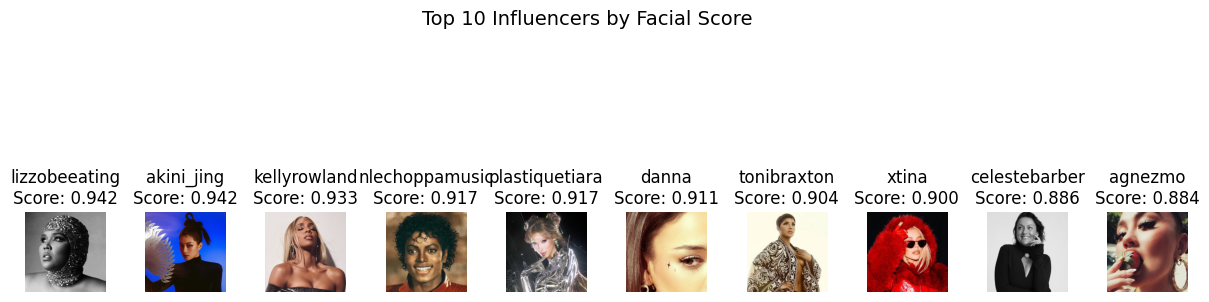

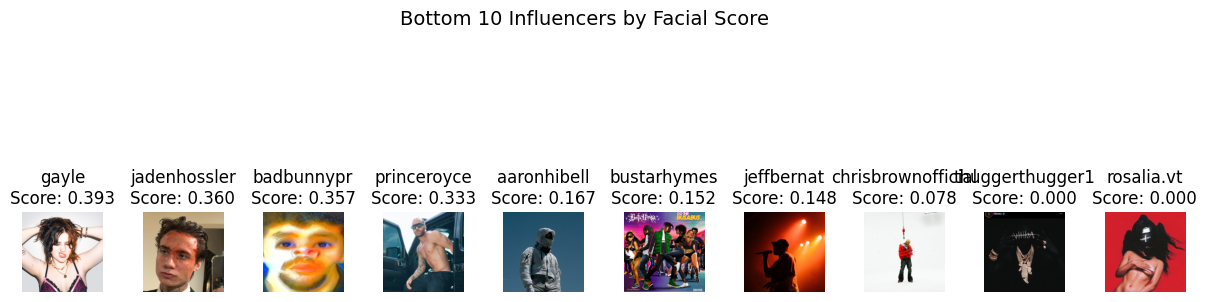

,influencer,score_1,score_2,score_3,avg_score
0,lizzobeeating,0.875,1.000,0.950,0.941667
1,akini_jing,0.950,0.950,0.925,0.941667
2,kellyrowland,0.950,0.900,0.950,0.933333
3,nlechoppamusic,0.900,0.900,0.950,0.916667
4,plastiquetiara,0.950,0.950,0.850,0.916667
5,danna,0.950,0.891,0.891,0.910667
6,tonibraxton,0.923,0.915,0.875,0.904333
7,xtina,0.900,0.850,0.950,0.900000
8,celestebarber,0.875,0.934,0.850,0.886333
9,agnezmo,0.950,0.812,0.891,0.884333


In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

# CSV 파일 경로 설정
directory = "./"  # CSV 파일이 있는 디렉토리
image_directory = "./celebrities"  # 이미지가 있는 디렉토리
csv_filename = "sorted_facial_scores.csv"
csv_path = os.path.join(directory, csv_filename)

# CSV 파일 로드
df = pd.read_csv(csv_path)

# 상위 10위 및 하위 10위 추출
top_10 = df.head(10)
bottom_10 = df.tail(10)

# 시각화 함수 정의
def plot_scores_with_images(df_subset, title):
    fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=len(df_subset), gridspec_kw={'wspace': 0.5})

    if len(df_subset) == 1:  # 단일 항목일 경우 리스트가 아닌 단일 축을 받음
        axes = [axes]

    for ax, (_, row) in zip(axes, df_subset.iterrows()):
        influencer = row["influencer"]
        avg_score = row["avg_score"]
        image_path = os.path.join(image_directory, f"{influencer}_profile_pic.jpg")

        if os.path.exists(image_path):
            image = Image.open(image_path)
            ax.imshow(image)
            ax.axis("off")
            ax.set_title(f"{influencer}\nScore: {avg_score:.3f}")
        else:
            ax.set_title(f"{influencer}\n(No Image)")
            ax.axis("off")

    plt.suptitle(title, fontsize=14)
    plt.show()

# 상위 10위 시각화 (이미지 포함)
plot_scores_with_images(top_10, "Top 10 Influencers by Facial Score")

# 하위 10위 시각화 (이미지 포함)
plot_scores_with_images(bottom_10, "Bottom 10 Influencers by Facial Score")

# 데이터프레임 출력
display(pd.concat([top_10, bottom_10]))

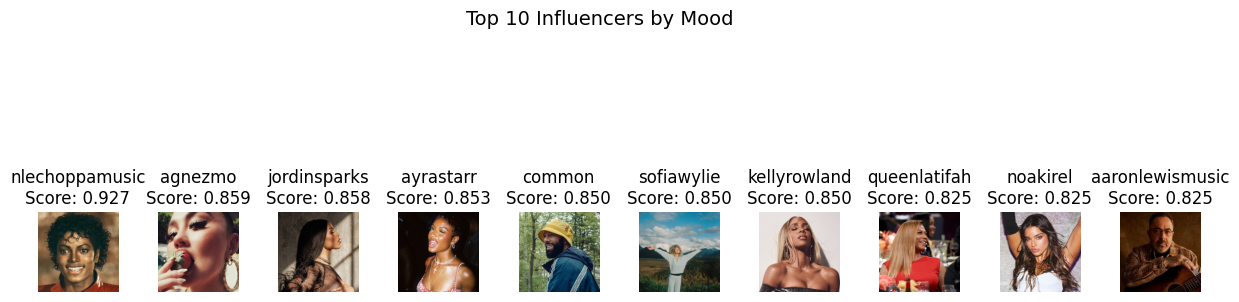

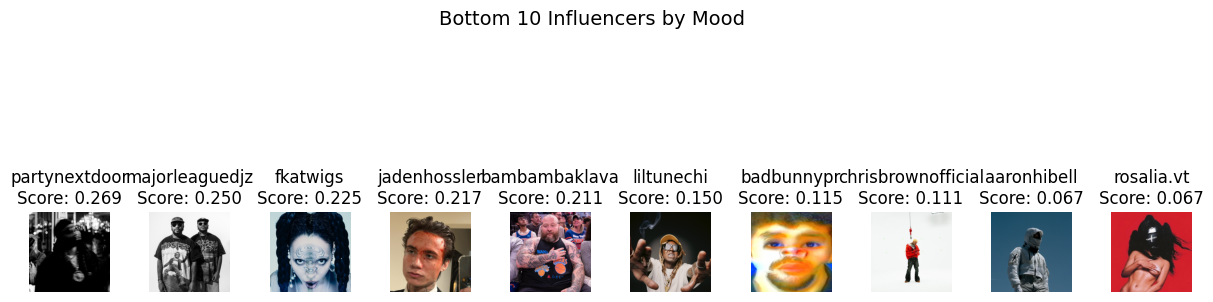

,influencer,score_1,score_2,score_3,avg_score
0,nlechoppamusic,0.930,1.000,0.850,0.926667
1,agnezmo,0.750,0.891,0.935,0.858667
2,jordinsparks,0.875,0.875,0.825,0.858333
3,ayrastarr,0.750,0.934,0.875,0.853000
4,common,0.825,0.850,0.875,0.850000
5,sofiawylie,0.875,0.875,0.800,0.850000
6,kellyrowland,0.825,0.850,0.875,0.850000
7,queenlatifah,0.875,0.750,0.850,0.825000
8,noakirel,0.750,0.875,0.850,0.825000
9,aaronlewismusic,0.750,0.750,0.975,0.825000


In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

# CSV 파일 경로 설정
directory = "./"  # CSV 파일이 있는 디렉토리
image_directory = "./celebrities"  # 이미지가 있는 디렉토리
csv_filename = "sorted_mood_scores.csv"
csv_path = os.path.join(directory, csv_filename)

# CSV 파일 로드
df = pd.read_csv(csv_path)

# 상위 10위 및 하위 10위 추출
top_10 = df.head(10)
bottom_10 = df.tail(10)

# 시각화 함수 정의
def plot_scores_with_images(df_subset, title):
    fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=len(df_subset), gridspec_kw={'wspace': 0.5})

    if len(df_subset) == 1:  # 단일 항목일 경우 리스트가 아닌 단일 축을 받음
        axes = [axes]

    for ax, (_, row) in zip(axes, df_subset.iterrows()):
        influencer = row["influencer"]
        avg_score = row["avg_score"]
        image_path = os.path.join(image_directory, f"{influencer}_profile_pic.jpg")

        if os.path.exists(image_path):
            image = Image.open(image_path)
            ax.imshow(image)
            ax.axis("off")
            ax.set_title(f"{influencer}\nScore: {avg_score:.3f}")
        else:
            ax.set_title(f"{influencer}\n(No Image)")
            ax.axis("off")

    plt.suptitle(title, fontsize=14)
    plt.show()

# 상위 10위 시각화 (이미지 포함)
plot_scores_with_images(top_10, "Top 10 Influencers by Mood")

# 하위 10위 시각화 (이미지 포함)
plot_scores_with_images(bottom_10, "Bottom 10 Influencers by Mood")

# 데이터프레임 출력
display(pd.concat([top_10, bottom_10]))

In [5]:
from glob import glob
import pandas as pd

celebrities_directory='./celebrities'

image_files = glob(os.path.join(celebrities_directory, "*_profile_pic.jpg"))
results = []

for image_path in image_files:
    influencer = os.path.basename(image_path).split("_profile_pic.jpg")[0]
    scores = [get_mood_score(image_path) for _ in range(3)]
    avg_score = sum(scores) / len(scores)
    results.append([influencer, *scores, avg_score])

# 데이터프레임 생성 및 정렬
df = pd.DataFrame(results, columns=["influencer", "score_1", "score_2", "score_3", "avg_score"])
df = df.sort_values(by="avg_score", ascending=False)

# CSV 저장
df.to_csv("sorted_mood_scores.csv", index=False)
print(f"CSV 저장 완료: sorted_mood_scores.csv")

NameError: name 'get_mood_score' is not defined

In [6]:
pixel_values = load_image(f'./mood.jpg', max_num=12).to(torch.bfloat16).cuda()
generation_config = dict(max_new_tokens=1024, do_sample=True)
generation_config["pad_token_id"] = 151645
question = '''<image>\nYou MUST ONLY output a single number between 0 and 1 with three decimal places, representing how appealing this photo's overall atmosphere would be to potential romantic partners.

Rules:
1. Output format: 0.XXX (e.g., 0.234, 0.567, 0.891)
2. No text, explanation, or any other content
3. Just one line with the score
4. Must be exactly in the format: 0.XXX

Scoring reference:
1.000: Exceptionally appealing - creates perfect romantic attraction and interest
0.800: Very appealing - highly likely to attract romantic interest
0.500: Average - typical level of romantic appeal
0.200: Below average - unlikely to create romantic interest
0.000: Poor - fails to create any romantic appeal

Consider these aspects for scoring:
1. Romantic charm and appeal in pose/expression
2. How inviting and approachable they appear
3. Whether the mood suggests dating potential
4. Whether the setting/situation is attractive to potential partners
5. How well the photo showcases appealing personality traits
6. Whether the overall image would make someone want to date them

Rate the photo's atmosphere score now:'''
response = model.chat(tokenizer, pixel_values, question, generation_config)
print(f'User: {question}\nAssistant: {response}')

User: <image>
You MUST ONLY output a single number between 0 and 1 with three decimal places, representing how appealing this photo's overall atmosphere would be to potential romantic partners.

Rules:
1. Output format: 0.XXX (e.g., 0.234, 0.567, 0.891)
2. No text, explanation, or any other content
3. Just one line with the score
4. Must be exactly in the format: 0.XXX

Scoring reference:
1.000: Exceptionally appealing - creates perfect romantic attraction and interest
0.800: Very appealing - highly likely to attract romantic interest
0.500: Average - typical level of romantic appeal
0.200: Below average - unlikely to create romantic interest
0.000: Poor - fails to create any romantic appeal

Consider these aspects for scoring:
1. Romantic charm and appeal in pose/expression
2. How inviting and approachable they appear
3. Whether the mood suggests dating potential
4. Whether the setting/situation is attractive to potential partners
5. How well the photo showcases appealing personality 

In [8]:
os.listdir("./ai_imgs")[1].split("_")[1][0] == "0"

True

In [9]:
import pandas as pd
unique_list = pd.read_csv("./data/user.tsv")["id"].to_list()

In [10]:
pic_list = os.listdir("./ai_imgs")
unique_list = []
for i in pic_list:
    if i.split("_")[1].startswith("0"):
        unique_list.append(i)

In [11]:
len(unique_list) /4

10418.75

In [12]:
import tqdm
pic_list = os.listdir("./ai_imgs")
beauty_score = []
with torch.no_grad():
    
    for i in tqdm.tqdm(range(10418)):
        pixel_values1 = load_image(f'./ai_imgs/{unique_list[4*i]}', max_num=12).to(torch.bfloat16).to(device)
        pixel_values2 = load_image(f'./ai_imgs/{unique_list[4*i+1]}', max_num=12).to(torch.bfloat16).to(device)
        pixel_values3 = load_image(f'./ai_imgs/{unique_list[4*i+2]}', max_num=12).to(torch.bfloat16).to(device)
        pixel_values4 = load_image(f'./ai_imgs/{unique_list[4*i+3]}', max_num=12).to(torch.bfloat16).to(device)

        num_patches_list = [pixel_values1.size(0), pixel_values2.size(0),pixel_values3.size(0), pixel_values4.size(0)]
        pixel_values = torch.cat((pixel_values1, pixel_values2, pixel_values3, pixel_values4), dim=0)

        questions = [question] * len(num_patches_list)
        responses = model.batch_chat(tokenizer, pixel_values,
                                    num_patches_list=num_patches_list,
                                    questions=questions,
                                    generation_config=generation_config)
        beauty_score += responses

100%|██████████| 10418/10418 [2:55:47<00:00,  1.01s/it] 


In [13]:
pixel_values1 = load_image(f'./ai_imgs/{unique_list[4*10418]}', max_num=12).to(torch.bfloat16).to(device)
pixel_values2 = load_image(f'./ai_imgs/{unique_list[4*10418+1]}', max_num=12).to(torch.bfloat16).to(device)
pixel_values3 = load_image(f'./ai_imgs/{unique_list[4*10418+2]}', max_num=12).to(torch.bfloat16).to(device)
num_patches_list = [pixel_values1.size(0), pixel_values2.size(0),pixel_values3.size(0)]
pixel_values = torch.cat((pixel_values1, pixel_values2, pixel_values3), dim=0)

questions = [question] * len(num_patches_list)
responses = model.batch_chat(tokenizer, pixel_values,
                            num_patches_list=num_patches_list,
                            questions=questions,
                            generation_config=generation_config)
beauty_score += responses

In [14]:
len(beauty_score)

41675

In [15]:
b = []
for i in beauty_score:
    try:
        b.append(float(i))
    except:
        b.append(0.650)

In [16]:
import numpy as np
np.array(b).mean()

0.6343922015596879

In [17]:
import pandas as pd
beauty_df = pd.DataFrame([unique_list, b]).T
beauty_df.columns = ["id", "mood"]
beauty_df.to_csv("./mood_df.csv", index =False)

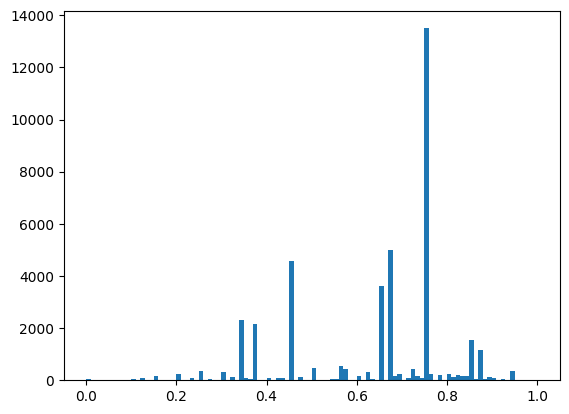

In [18]:
import matplotlib.pyplot as plt
plt.hist(b, bins =100)
plt.show()

In [29]:
beauty_df

,id,beauty
0,6308768_0.jpg,0.85
1,1724267_0.jpg,0.35
2,6328275_0.jpg,0.572
3,6345366_0.jpg,0.723
4,5023372_0.jpg,0.75
...,...,...
41670,1196974_0.jpg,0.578
41671,5064188_0.jpg,0.885
41672,4631947_0.jpg,0.85
41673,6360940_0.jpg,0.75


import tqdm
pic_list = os.listdir("./ai_imgs")
beauty_score = []
with torch.no_grad():
    
    for i in tqdm.tqdm(range(15000)):
        pixel_values1 = load_image(f'./ai_imgs/{pic_list[8*i]}', max_num=12).to(torch.bfloat16).to(device)
        pixel_values2 = load_image(f'./ai_imgs/{pic_list[8*i+1]}', max_num=12).to(torch.bfloat16).to(device)
        pixel_values3 = load_image(f'./ai_imgs/{pic_list[8*i+2]}', max_num=12).to(torch.bfloat16).to(device)
        pixel_values4 = load_image(f'./ai_imgs/{pic_list[8*i+3]}', max_num=12).to(torch.bfloat16).to(device)
        pixel_values5 = load_image(f'./ai_imgs/{pic_list[8*i+4]}', max_num=12).to(torch.bfloat16).to(device)
        pixel_values6 = load_image(f'./ai_imgs/{pic_list[8*i+5]}', max_num=12).to(torch.bfloat16).to(device)
        pixel_values7 = load_image(f'./ai_imgs/{pic_list[8*i+6]}', max_num=12).to(torch.bfloat16).to(device)
        pixel_values8 = load_image(f'./ai_imgs/{pic_list[8*i+7]}', max_num=12).to(torch.bfloat16).to(device)
        num_patches_list = [pixel_values1.size(0), pixel_values2.size(0),pixel_values3.size(0), pixel_values4.size(0), pixel_values5.size(0), pixel_values6.size(0),pixel_values7.size(0), pixel_values8.size(0)]
        pixel_values = torch.cat((pixel_values1, pixel_values2, pixel_values3, pixel_values4, pixel_values5, pixel_values6, pixel_values7, pixel_values8), dim=0)

        questions = [question] * len(num_patches_list)
        responses = model.batch_chat(tokenizer, pixel_values,
                                    num_patches_list=num_patches_list,
                                    questions=questions,
                                    generation_config=generation_config)
        beauty_score += responses

In [27]:
b = []
for i in beauty_score:
    try:
        b.append(float(i))
    except:
        b.append(2)

In [34]:
c = []
for i , k in enumerate(b):
    if k == 0:
        c.append(i)


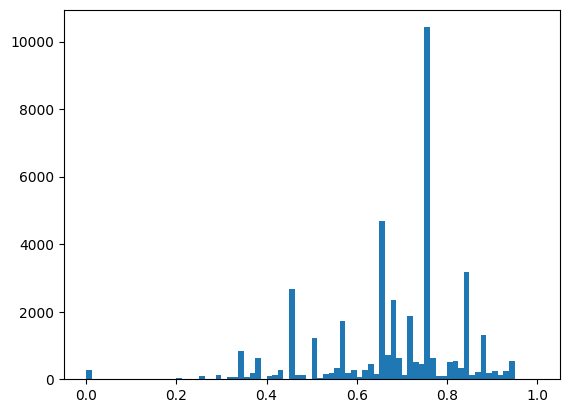

In [31]:
import matplotlib.pyplot as plt

plt.hist(b,bins = 80, range = (0,1))
plt.show()


In [28]:
!nvidia-smi

Tue Feb  4 05:45:09 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:31:00.0 Off |                  Off |
| 34%   37C    P2              60W / 450W |  12278MiB / 24564MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--